# Call Libraries

In [1]:
import matlab.engine
from multiprocessing import Pool
import multiprocessing
from tqdm import tqdm
from joblib import Parallel, delayed
from mpire import WorkerPool
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

c:\Users\Remote\anaconda3\envs\PyMatlab\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Remote\AppData\Local\Temp\ipykernel_26244\3148525863.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/lates

# Run Matlab For all Site Locations

In [2]:
# Chose the number of envs based on the amount of memory you have
# I have 64GB of RAM, so I can run 10 envs at the same time. 
#Every 100 runs take 8 minutes
#50*50 = 2500 runs = 200 minutes = 3.3 hours

#Set XY location and run on workspace

def Run_LF_KiteALLSites(NumEnvs=10,X_range=50,Y_range=50):
    
    Envs=[matlab.engine.start_matlab() for i in range(NumEnvs)] #Create envs
    for i in range(NumEnvs):
        Envs[i].eval("File='DataSetPlatform.mat';"+"load(File);" ,nargout=0)


    Solutions=[]
    #Command used in the workspace to input xy location
    LocationsCMD=[]
    for xInd in range(1,X_range+1,1):
        for yInd in range(1,Y_range+1,1):
            Location=str('xInd ='+str(xInd)+'; yInd ='+str(yInd)+';')
            LocationsCMD.append(Location)

    G_count=0
    while G_count!=len(LocationsCMD):
        G_count=len(Solutions)
        print("%.2f %% complete" % (G_count/len(LocationsCMD)*100))
        
        NumRuns=np.min([len(Envs),len(LocationsCMD)-G_count]) #Number of runs to do in parallel

        for i in range(0,NumRuns,1):
            Envs[i].eval(LocationsCMD[G_count+i],nargout=0) #Input xy location
            

        #Separate loop to run in parallel (only for running in parallel)
        for i in range(0,NumRuns,1):
            Envs[i].specXY_plantOptMultiObj_LF_Python(nargout=0,background=True) #Solve problem in background


        #Get solutions from workspace
        for i in range(0,NumRuns,1):
            #Get variables from workspace
            uopt=Envs[i].workspace['uopt']
            mFuse=Envs[i].workspace['mFuse']
            mWing=Envs[i].workspace['mWing']
            Power=Envs[i].workspace['Power']
            LCOEBest=Envs[i].workspace['LCOEBest']
            CLCD=Envs[i].workspace['CLCD']
            xInd=Envs[i].workspace['xInd']
            yInd=Envs[i].workspace['yInd']

                
            XYKite = {
                "X": xInd,
                "Y": yInd,
                "uopt": uopt,
                "mFuse": mFuse,
                "mWing": mWing,
                "Power": Power,
                "LCOEBest": LCOEBest,
                "CLCD": CLCD
            }

            Solutions.append(XYKite)

    latVec=Envs[0].workspace["DataSet"]["latVec"][0]
    lonVec=Envs[0].workspace["DataSet"]["lonVec"][0]

    latVec=np.array(lonVec)[0]
    lonVec=np.array(lonVec)[0]

    for i in range(NumEnvs):
        Envs[i].quit()

    np.savez("LF_KiteDesigns.npz",Results=Solutions,lat=latVec,long=lonVec)
    return Solutions, latVec, lonVec

#Solutions, latVec, lonVec=Run_LF_KiteALLSites(NumEnvs=10,X_range=50,Y_range=50)
#LF_KiteOnly: Optimal low fidelity kites and average generation

In [3]:
Solutions, latVec, lonVec=Run_LF_KiteALLSites(NumEnvs=10,X_range=50,Y_range=50)

0.00 % complete
0.40 % complete
0.80 % complete
1.20 % complete
1.60 % complete
2.00 % complete
2.40 % complete
2.80 % complete
3.20 % complete
3.60 % complete
4.00 % complete
4.40 % complete
4.80 % complete
5.20 % complete
5.60 % complete
6.00 % complete
6.40 % complete
6.80 % complete
7.20 % complete
7.60 % complete
8.00 % complete
8.40 % complete
8.80 % complete
9.20 % complete
9.60 % complete
10.00 % complete
10.40 % complete
10.80 % complete
11.20 % complete
11.60 % complete
12.00 % complete
12.40 % complete
12.80 % complete
13.20 % complete
13.60 % complete
14.00 % complete
14.40 % complete
14.80 % complete
15.20 % complete
15.60 % complete
16.00 % complete
16.40 % complete
16.80 % complete
17.20 % complete
17.60 % complete
18.00 % complete
18.40 % complete
18.80 % complete
19.20 % complete
19.60 % complete
20.00 % complete
20.40 % complete
20.80 % complete
21.20 % complete
21.60 % complete
22.00 % complete
22.40 % complete
22.80 % complete
23.20 % complete
23.60 % complete
24.00

# Update Generation as a Time Series (From Mary)

In [6]:
# I have 64GB of RAM, so I can run 10 envs at the same time. 
#2500 runs = 30 minutes

Data=np.load("SaveSolutions/Save_Platform.npz",allow_pickle=True)
def UpdateGenerationTS (Data=Data, NumEnvs=15):

    Results=Data["Results"]
    lat=Data["lat"]
    long=Data["long"]

    Envs=[matlab.engine.start_matlab() for i in range(NumEnvs)] #Create envs
    for i in range(NumEnvs):
        Envs[i].eval("File='DataSetPlatform.mat';"+"load(File);" ,nargout=0)


    cmd1=[]
    cmd2=[]

    for i in range(len(Results)):
        X=Results[i]["X"]
        Y=Results[i]["Y"]
        uopt  =Results[i]["uopt"]

        cmd1_tmp = str('xSite =['+str(X)+','+str(Y)+'];')
        cmd2_tmp = str('uGeo =['+str(uopt[0][0])+','+str(uopt[0][1])+','+str(uopt[0][2])+','+str(uopt[0][3])+','+str(15000)+'];')
        cmd1.append(cmd1_tmp)
        cmd2.append(cmd2_tmp)

    G_count=0
    NumRuns=0
    while G_count!=len(Results):

        G_count=G_count+NumRuns

        print("%.2f %% complete" % (G_count/len(Results)*100))

        NumRuns=np.min([len(Envs),len(Results)-G_count]) #Number of runs to do in parallel
        
        for i in range(0,NumRuns,1):
            Envs[i].eval(cmd1[G_count+i],nargout=0) #Inputs
            Envs[i].eval(cmd2[G_count+i],nargout=0) #Inputs

        #Separate loop to run in parallel (only for running in parallel)
        for i in range(0,NumRuns,1):
            Envs[i].powerFunc_Python(nargout=0,background=True) #Solve problem in background

        for i in range(0,NumRuns,1):   
            Jopt_vec  =Envs[i].workspace["Jopt_vec"][0]
            theta_vec =Envs[i].workspace["theta_vec"][0]
            l_vec     =Envs[i].workspace["l_vec"][0]

            Results[G_count+i]["Jopt_vec"]=Jopt_vec
            Results[G_count+i]["theta_vec"]=theta_vec
            Results[G_count+i]["l_vec"]=l_vec

    for i in range(NumEnvs):
        Envs[i].quit()

    np.savez("LF_KiteTimeSeriesGeneration.npz",Results=Results,lat=lat,long=long)
    #LF_KiteOnly_TT_Float: TimeSeries of Energy Generation

UpdateGenerationTS()

0.00 % complete
0.60 % complete
1.20 % complete
1.80 % complete
2.40 % complete
3.00 % complete
3.60 % complete
4.20 % complete
4.80 % complete
5.40 % complete
6.00 % complete
6.60 % complete
7.20 % complete
7.80 % complete
8.40 % complete
9.00 % complete
9.60 % complete
10.20 % complete
10.80 % complete
11.40 % complete
12.00 % complete
12.60 % complete
13.20 % complete
13.80 % complete
14.40 % complete
15.00 % complete
15.60 % complete
16.20 % complete
16.80 % complete
17.40 % complete
18.00 % complete
18.60 % complete
19.20 % complete
19.80 % complete
20.40 % complete
21.00 % complete
21.60 % complete
22.20 % complete
22.80 % complete
23.40 % complete
24.00 % complete
24.60 % complete
25.20 % complete
25.80 % complete
26.40 % complete
27.00 % complete
27.60 % complete
28.20 % complete
28.80 % complete
29.40 % complete
30.00 % complete
30.60 % complete
31.20 % complete
31.80 % complete
32.40 % complete
33.00 % complete
33.60 % complete
34.20 % complete
34.80 % complete
35.40 % comple

# Plots

In [ ]:
Data=np.load("Save_Platform.npz",allow_pickle=True)
Results=Data["Results"]
lat=Data["lat"]
long=Data["long"]

In [ ]:
def PlotData(Variable,Lat=lat,Long=long,Variable2=Variable2):
  ShapeFileCoast="./GEO_data/ne_10m_coastline.shp"
  ShapeFileStates="./GEO_data/ne_10m_admin_1_states_provinces_lines.shp"
  X_LAT=np.zeros((int(len(Lat)*len(Long))),dtype=float)
  Y_LONG=np.zeros((int(len(Lat)*len(Long))),dtype=float)

  min_latitude=np.min(Lat)
  max_latitude=np.max(Lat)

  min_longitude=np.min(Long)
  max_longitude=np.max(Long)

  xlim =[min_longitude,max_longitude]
  ylim=[min_latitude, max_latitude]

  xlim =[-78.6,-74.4]
  ylim=[33.7, 36.7]

  df = gpd.read_file(ShapeFileCoast)
  df1 = gpd.read_file(ShapeFileStates)

  fig, ax = plt.subplots(figsize  = None)
  df.plot(color='black',linewidth=1,ax=ax)
  df1.plot(color='black',linewidth=1,ax=ax)

  count=0
  for I_lat in range(len(Lat)):
    for I_long in range(len(Long)):

      Y_LONG[count]=Lat[I_lat]
      X_LAT[count]=Long[I_long]
      count=count+1

  Variable=np.reshape(Variable,(-1))
#   X_LAT=X_LAT[Variable<9000]
#   Y_LONG=Y_LONG[Variable<9000]
#   Variable=Variable[Variable<9000]

  Variable2=np.reshape(Variable2,(-1))
  X_LAT=X_LAT[Variable2<300]
  Y_LONG=Y_LONG[Variable2<300]
  Variable=Variable[Variable2<300]

  plt.scatter(X_LAT,Y_LONG,c=Variable, s=5, cmap='jet')
  

  ticks = np.linspace(Variable.min(), Variable.max(), 10, endpoint=True)
  #ticks = np.linspace(Variable.min(), 200, 10, endpoint=True)
  clb=plt.colorbar(format='%.1f', ticks=ticks)

  clb.ax.set_title('LCOE [$/MWh]')
  #clb.ax.set_title('mFuse [kg]')
  #clb.ax.set_title('Power [KW]')
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)

  plt.savefig("Power",dpi=1200)
  return plt.show()


In [ ]:
Variable=np.ones((50,50))*-1
Variable2=np.ones((50,50))*-1

for i in range(len(Results)):
    a=Results[i]["X"]-1
    b=Results[i]["Y"]-1
    c=Results[i]["LCOEBest"]*1000
    Variable[a,b]=c
    Variable2[a,b]=Results[i]["LCOEBest"]*1000

In [ ]:
PlotData(Variable, Lat=lat[0], Long=long[0])

## Report Q2 Plots

In [20]:
#Data=np.load("SaveSeabed.npz",allow_pickle=True)
Data=np.load("./SaveSolutions/Save_Platform.npz",allow_pickle=True)
Results=Data["Results"]
lat=Data["lat"]
long=Data["long"]

Variable=np.ones((50,50))*-1
Variable2=np.ones((50,50))*-1

for i in range(len(Results)):
    a=Results[i]["X"]-1
    b=Results[i]["Y"]-1
    c=Results[i]["LCOEBest"]*1000
    #c=Results[i]["Power"]
    #c=Results[i]["mFuse"]
    #c=Results[i]["mWing"]
    Variable[a,b]=c
    Variable2[a,b]=Results[i]["LCOEBest"]*1000

def PlotData(Variable,Lat=lat,Long=long,Variable2=Variable2):
    ShapeFileCoast="./GEO_data/ne_10m_coastline.shp"
    ShapeFileStates="./GEO_data/ne_10m_admin_1_states_provinces_lines.shp"
    X_LAT=np.zeros((int(len(Lat)*len(Long))),dtype=float)
    Y_LONG=np.zeros((int(len(Lat)*len(Long))),dtype=float)

    min_longitude=-78.5
    max_longitude=-74.5+1/50

    min_latitude=33.5 
    max_latitude=37+1/50

    xlim =[min_longitude,max_longitude]
    ylim=[min_latitude, max_latitude]

    
    df = gpd.read_file(ShapeFileCoast)
    df1 = gpd.read_file(ShapeFileStates)

    fig, ax = plt.subplots(figsize  = None)
    df.plot(color='black',linewidth=1,ax=ax)
    df1.plot(color='black',linewidth=1,ax=ax)

    count=0
    for I_lat in range(len(Lat)):
        for I_long in range(len(Long)):

          Y_LONG[count]=Lat[I_lat]
          X_LAT[count]=Long[I_long]
          count=count+1

        
    Variable=np.reshape(Variable,(-1))
#     X_LAT=X_LAT[Variable<9000]
#     Y_LONG=Y_LONG[Variable<9000]
#     Variable=Variable[Variable<9000]

    Variable2=np.reshape(Variable2,(-1))
    X_LAT=X_LAT[Variable2<300]
    Y_LONG=Y_LONG[Variable2<300]
    Variable=Variable[Variable2<300]

    plt.scatter(X_LAT,Y_LONG,c=Variable, s=5, cmap='jet')


    ticks = np.linspace(Variable.min(), Variable.max(), 10, endpoint=True)
    #ticks = np.linspace(Variable.min(), 200, 10, endpoint=True)
    clb=plt.colorbar(format='%.f', ticks=ticks)


    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    
    clb.ax.set_title('LCOE $/MWh')
    #clb.ax.set_title('Power [kW]')
    #clb.ax.set_title('mFuse [kg]')
    #clb.ax.set_title('mWing [kg]')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    plt.savefig("mWing_KiteSeabed.png",bbox_inches='tight',dpi=700)
    return plt.show()

In [23]:
np.sum(Variable<100)

485

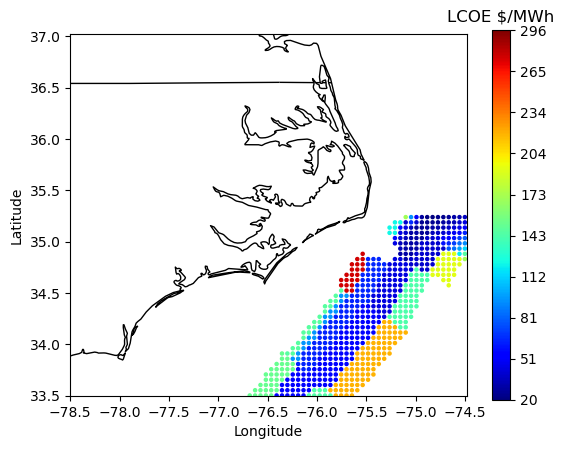

In [21]:
PlotData(Variable, Lat=lat[0], Long=long[0])

## Combine Wind Kite

In [ ]:
#Data=np.load("SaveSeabed.npz",allow_pickle=True)
Data=np.load("Save_Platform.npz",allow_pickle=True)
Results=Data["Results"]
lat=Data["lat"]
long=Data["long"]

Variable=np.ones((50,50))*-1
#Variable2=np.ones((50,50))*-1

for i in range(len(Results)):
    a=Results[i]["X"]-1
    b=Results[i]["Y"]-1
    c=Results[i]["LCOEBest"]*1000
    c=Results[i]["Power"]
    #c=Results[i]["mFuse"]
    c=Results[i]["mWing"]
    Variable[a,b]=c
    Variable2[a,b]=Results[i]["LCOEBest"]*1000

def PlotData(Variable,Lat=lat,Long=long,Variable2=Variable2):
    ShapeFileCoast="./GEO_data/ne_10m_coastline.shp"
    ShapeFileStates="./GEO_data/ne_10m_admin_1_states_provinces_lines.shp"
    X_LAT=np.zeros((int(len(Lat)*len(Long))),dtype=float)
    Y_LONG=np.zeros((int(len(Lat)*len(Long))),dtype=float)

    min_longitude=-78.5
    max_longitude=-74.5+1/50

    min_latitude=33.5 
    max_latitude=37+1/50

    xlim =[min_longitude,max_longitude]
    ylim=[min_latitude, max_latitude]

    
    df = gpd.read_file(ShapeFileCoast)
    df1 = gpd.read_file(ShapeFileStates)

    fig, ax = plt.subplots(figsize  = None)
    df.plot(color='black',linewidth=1,ax=ax)
    df1.plot(color='black',linewidth=1,ax=ax)

    count=0
    for I_lat in range(len(Lat)):
        for I_long in range(len(Long)):

          Y_LONG[count]=Lat[I_lat]
          X_LAT[count]=Long[I_long]
          count=count+1